In [37]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score,  mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


## Load data

In [38]:
for file_name in os.listdir("files"):
    if file_name.endswith('.csv'):
        file_path = os.path.join("files", file_name)

        df_name = os.path.splitext(file_name)[0]
        globals()[df_name] = pd.read_csv(file_path)


## Simplification of categories

In [39]:
# sports
learn_dataset_sport = pd.merge(learn_dataset_sport, code_Sports, left_on="Sports", right_on="Code")
learn_dataset_sport["Sports_Category"] = learn_dataset_sport["Categorie"]
learn_sports = learn_dataset_sport[["PRIMARY_KEY", "Sports_Category"]]

# departments into regions
def merge_and_extract_region(df, merge_column, region_column_name):
    df = pd.merge(df, departments, left_on=merge_column, right_on="DEP")
    df[region_column_name] = df["REG"]
    df.drop(["Nom du département", "REG", "DEP", merge_column], axis=1, inplace=True)
    return df


learn_dataset_job = merge_and_extract_region(
    learn_dataset_job, merge_column="JOB_DEP", region_column_name="REG_JOB"
)

learn_dataset_retired_jobs = merge_and_extract_region(
    learn_dataset_retired_jobs, merge_column="JOB_DEP", region_column_name="REG_JOB"
)

learn_dataset_retired_jobs = merge_and_extract_region(
    learn_dataset_retired_jobs, merge_column="FORMER_DEP", region_column_name="REG_FORMER"
)

In [40]:
#Economic sector into fewer categories (and numeric instead of object/string)
def sector_mapping(nace_code):
    if nace_code == "AZ":  
        return "Agriculture, forestry and fishing)"
    elif "BZ" <= nace_code <= "EZ":
        return "Manufacturing, mining and quarrying and other industrial activities"
    elif nace_code == "FZ": 
        return "Construction"
    elif "GZ" <= nace_code <= "IZ":  
        return "Wholesale and retail trade, transportation and storage, accommodation and food service activities"
    elif "JA" <= nace_code <= "JC":
        return "Information and communication"
    elif nace_code == "KZ": 
        return "Financial and insurance activities"
    elif nace_code == "LZ": 
        return "Real estate activities"
    elif "MA" <= nace_code <= "NZ":
        return "Professional, scientific, technical, administrative and support service activities"
    elif "OZ" <= nace_code <= "QB":
        return "Public administration and defence, education, human health and social work activities"
    elif "RZ" <= nace_code <= "UZ":
        return "Other services activities"
    else:
        return "Unknown Sector"

code_Economic_sector["Nomenclature"] = code_Economic_sector["Code"].map(sector_mapping)
code_Economic_sector["Economic_sector_num"] = pd.factorize(code_Economic_sector["Nomenclature"])[0] + 1

code_HIGHEST_CREDENTIAL["HIGHEST_CREDENTIAL_num"] = pd.factorize(code_HIGHEST_CREDENTIAL["Code"])[0] + 1
code_act["act_num"] = pd.factorize(code_act["Code"])[0] + 1


## Merging

In [41]:
learn_data = learn_dataset
learn_data = learn_data[['target'] + [col for col in learn_data.columns if col != 'target']]

learn_data = pd.merge(learn_data, code_act, left_on="act", right_on="Code", how="left")
learn_data.drop(["Code", "Libellé"], axis=1, inplace=True)
learn_data = pd.merge(learn_data, code_HIGHEST_CREDENTIAL, left_on="HIGHEST_CREDENTIAL", right_on="Code", how="left")
learn_data.drop(["Code", "Libellé", "HIGHEST_CREDENTIAL"], axis=1, inplace=True)

learn_data = pd.merge(learn_data, city_pop, on="INSEE_CODE", how="left")
learn_data = pd.merge(learn_data, city_loc, on="INSEE_CODE", how="left")

In [42]:
learn_dfs = [learn_dataset_emp_contract, learn_dataset_job, learn_dataset_retired_former, learn_dataset_retired_jobs, learn_dataset_retired_pension, learn_sports]

for df in learn_dfs:
    learn_data = pd.merge(learn_data, df, on="PRIMARY_KEY", how="outer")

In [43]:
def combine_columns(col_x, col_y):
    return col_x.fillna(col_y) if col_y is not None else col_x

for column in learn_data.columns:
    if column.endswith('_x'):
        base_column = column[:-2]
        y_column = base_column + '_y'
        if y_column in learn_data.columns:
            # Combine the columns
            learn_data[base_column] = combine_columns(learn_data[column], learn_data[y_column])
            # Drop the original `_x` and `_y` columns
            learn_data = learn_data.drop(columns=[column, y_column])


## Formatting - for Random Forest

In [44]:
def household_num(value):
    parts = value.split('|')  # Split the value by '|'
    if parts[1] in {'1', '2', '3'}:  # For M|1|-- to M|3|--
        return int(parts[1])
    elif parts[1] == '4':  # For M|4|1 to M|4|4
        return 4 + (int(parts[2]) - 1)  # 4 + (1-1), 4 + (2-1), etc.
    return None  # Handle unexpected cases gracefully

In [45]:
code_HOUSEHOLD_TYPE['HOUSEHOLD_TYPE_num'] = code_HOUSEHOLD_TYPE['Code'].apply(household_num)
learn_data['HOUSEHOLD_TYPE'] = learn_data['HOUSEHOLD_TYPE'].apply(household_num)


In [46]:
#learn_data["JOB_42"] = learn_data["JOB_42"].str.extract(r'csp_(\d)')[0].astype(int)
#learn_data["FORMER_JOB_42"] = learn_data["FORMER_JOB_42"].str.extract(r'csp_(\d)')[0].astype("Int64")
learn_data["employee_count"] = learn_data["employee_count"].str.extract(r'tr_(\d)')[0].astype("Int64")
learn_data["Employer_category"] = learn_data["Employer_category"].str.extract(r'ct_(\d)')[0].astype("Int64")

learn_data = pd.merge(learn_data, code_Economic_sector, left_on="Economic_sector", right_on="Code", how="left")

learn_data = pd.merge(learn_data, code_work_description_map, left_on="work_description", right_on="N3", how="left")
learn_data.drop(["work_description", "N3", "N2"], axis=1, inplace=True)
learn_data["N1"] = learn_data["N1"].str.extract(r'csp_(\d)')[0].astype("Int64")
learn_data.rename(columns={"N1": "work_description"}, inplace=True)

learn_data["emp_contract"] = combine_columns(learn_data["emp_contract"], learn_data["former_emp_contract"])
learn_data["Pay"] = combine_columns(learn_data["Pay"], learn_data["RETIREMENT_PAY"])

In [47]:
def categorize_retirement_age():
    global learn_data  # Modify the global learn_data DataFrame
    
    # Ensure the retirement_age column is numeric
    learn_data['retirement_age'] = pd.to_numeric(learn_data['retirement_age'], errors='coerce')
    
    # Define the bins and corresponding labels
    bins = [0, 57, 60, 61, 63, 65, float('inf')]  # Specify edges for the ranges
    labels = ['<57', '57-59', '60', '61-62', '63-64', '65+']  # Labels for ranges

    # Initial categorization with pd.cut
    learn_data['retirement_age_cat'] = pd.cut(
        learn_data['retirement_age'], 
        bins=bins, 
        labels=labels, 
        right=False,  # Left-closed intervals
        include_lowest=True
    )


    # Ensure missing values in retirement_age_cat are handled properly
    learn_data['retirement_age_cat'] = learn_data['retirement_age_cat'].astype(object)  # Avoid ambiguity with NA
    
    # Handle exact matches for 60 and 65
    learn_data.loc[learn_data['retirement_age'] == 60, 'retirement_age_cat'] = '60'

# Call the function
categorize_retirement_age()

In [48]:
# types
learn_data["sex"] = pd.factorize(learn_data["sex"])[0]
learn_data["studying"] = learn_data["studying"].astype("int64")
learn_data["Sports_Category"] = learn_data["Sports_Category"].fillna(0).astype("int64")
learn_data["REG_JOB"] = pd.to_numeric(learn_data["REG_JOB"], errors='coerce').astype('Int64')
learn_data["REG_FORMER"] = pd.to_numeric(learn_data["REG_FORMER"], errors='coerce').astype('Int64')
learn_data["retirement_age"] = pd.to_numeric(learn_data["retirement_age"], errors='coerce').astype('Int64')
learn_data["WORKING_HOURS"] = pd.to_numeric(learn_data["WORKING_HOURS"], errors='coerce').astype('Int64')
learn_data["Economic_sector_num"] = pd.to_numeric(learn_data["Economic_sector_num"], errors='coerce').astype('Int64')
learn_data["Pay"] = pd.to_numeric(learn_data["Pay"], errors='coerce').astype('Int64')


In [49]:
def replace_na_with_category(column_name):
    global learn_data  # Ensures we modify the global learn_data directly

    # Convert the column to categorical
    learn_data[column_name] = learn_data[column_name].astype('category')
    
    # Define categories to add
    additional_categories = ['Unemployed', 'Retired_Missing', 'Employed_Missing']
    
    # Add the specified categories
    learn_data[column_name] = learn_data[column_name].cat.add_categories(additional_categories)
    
    learn_data.loc[(learn_data[column_name].isna()) & (learn_data['JOB_42'].astype(str).str.startswith('csp_7')), column_name] = 'Retired_Missing'
    learn_data.loc[(learn_data[column_name].isna()) & (learn_data['act_num'] == 1), column_name] = 'Employed_Missing'
    learn_data.loc[(learn_data[column_name].isna()) & ((learn_data['JOB_42'].astype(str).str.startswith('csp_8')) | (learn_data['act_num'] == 2)), column_name] = 'Unemployed'


In [50]:
replace_na_with_category("emp_contract")
replace_na_with_category("TYPE_OF_CONTRACT")
replace_na_with_category("WORK_CONDITION")
replace_na_with_category("labor_force_status")
replace_na_with_category("Economic_sector_num")
replace_na_with_category("REG_JOB")
replace_na_with_category("REG_FORMER")
replace_na_with_category("work_description")
replace_na_with_category("retirement_age_cat")

In [51]:
learn_data['Employer_category'] = learn_data.apply(
    lambda row: 10 if pd.isna(row['Employer_category']) and 
                        (str(row['JOB_42']).startswith('csp_8') or row['act_num'] == 2)  # unemployed
                else (0 if pd.isna(row['Employer_category']) else row['Employer_category']),  # employed and retired missing
    axis=1
)

learn_data['employee_count'] = learn_data.apply(
    lambda row: 7 if pd.isna(row['employee_count']) and 
                        (str(row['JOB_42']).startswith('csp_8') or row['act_num'] == 2)  # unemployed
                else (0 if pd.isna(row['employee_count']) else row['employee_count']),
    axis=1
)


In [52]:
learn_data.loc[learn_data['JOB_42'].astype(str).str.startswith('csp_7'), 'JOB_42'] = learn_data['FORMER_JOB_42']
learn_data.loc[(learn_data['emp_contract'] == 'Unemployed') & (learn_data['Pay'].isna()), 'Pay'] = 0
learn_data.loc[(learn_data['emp_contract'] == 'Unemployed') & (learn_data['WORKING_HOURS'].isna()), 'WORKING_HOURS'] = 0

learn_data = learn_data.drop(columns=["act", "former_emp_contract", "RETIREMENT_PAY", "retirement_age", "FORMER_JOB_42", "Economic_sector", "Code", "Libellé", "Nomenclature", "X", "Y"])

# Handling Missing Data

In [53]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)  #% of missing values
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #create result table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

print(missing_values_table(learn_data)) 

There are 2 columns that have missing values.
               Missing Values  % of Total Values
WORKING_HOURS            7345               14.7
Pay                      6961               13.9


## replacing missing values with mean

Replacement with values using external data for pay and working hours

In [54]:
#agriculture
learn_data.loc[(learn_data['JOB_42'].astype(str).str.startswith('csp_1')) & (learn_data['Pay'].isna()), 'Pay'] = 50000  # avg annual pay for farmers
learn_data.loc[(learn_data['JOB_42'].astype(str).str.startswith('csp_1')) & (learn_data['WORKING_HOURS'].isna()), 'WORKING_HOURS'] = 2860 #avg annual hours for agriculture

#artisans
learn_data.loc[(learn_data['JOB_42'] == 'csp_2_1') & (learn_data['Pay'].isna()), 'Pay'] = 24000 #median annual pay for artisans
learn_data.loc[(learn_data['JOB_42'] == 'csp_2_1') & (learn_data['WORKING_HOURS'].isna()), 'WORKING_HOURS'] = 2288

#commerçant
learn_data.loc[(learn_data['JOB_42'] == 'csp_2_2') & (learn_data['Pay'].isna()), 'Pay'] = 39937
learn_data.loc[(learn_data['JOB_42'] == 'csp_2_2') & (learn_data['WORKING_HOURS'].isna()), 'WORKING_HOURS'] = 2444

#chefs d'enterprise
learn_data.loc[(learn_data['JOB_42'] == 'csp_2_3') & (learn_data['Pay'].isna()), 'Pay'] = 58248
learn_data.loc[(learn_data['JOB_42'] == 'csp_2_3') & (learn_data['WORKING_HOURS'].isna()), 'WORKING_HOURS'] = 2704

In [55]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)  #% of missing values
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #create result table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

print(missing_values_table(learn_data)) 

There are 2 columns that have missing values.
               Missing Values  % of Total Values
WORKING_HOURS            3712                7.4
Pay                      3328                6.7


# Sorting

In [56]:
learn_rf = learn_data
learn_rf = learn_rf.sort_values(by='JOB_42', ascending=False)
learn_rf["JOB_42"] = pd.factorize(learn_rf["JOB_42"])[0]

learn_rf = learn_rf.sort_values(by='REG_JOB', ascending=False)
learn_rf["REG_JOB"] = pd.factorize(learn_rf["REG_JOB"])[0]

learn_rf = learn_rf.sort_values(by='Economic_sector_num', ascending=False)
learn_rf["Economic_sector_num"] = pd.factorize(learn_rf["Economic_sector_num"])[0]

learn_rf = learn_rf.sort_values(by='work_description', ascending=False)
learn_rf["work_description"] = pd.factorize(learn_rf["work_description"])[0]

learn_rf = learn_rf.sort_values(by='retirement_age_cat', ascending=False)
learn_rf["retirement_age_cat"] = pd.factorize(learn_rf["retirement_age_cat"])[0]

learn_rf = learn_rf.sort_values(by='REG_FORMER', ascending=False)
learn_rf["REG_FORMER"] = pd.factorize(learn_rf["REG_FORMER"])[0]

learn_rf = learn_rf.sort_values(by='TYPE_OF_CONTRACT', ascending=False)
learn_rf["TYPE_OF_CONTRACT"] = pd.factorize(learn_rf["TYPE_OF_CONTRACT"])[0]

learn_rf = learn_rf.sort_values(by='WORK_CONDITION', ascending=False)
learn_rf["WORK_CONDITION"] = pd.factorize(learn_rf["WORK_CONDITION"])[0]

learn_rf = learn_rf.sort_values(by='labor_force_status', ascending=False)
learn_rf["labor_force_status"] = pd.factorize(learn_rf["labor_force_status"])[0]

learn_rf = learn_rf.sort_values(by='emp_contract', ascending=False)
learn_rf["emp_contract"] = pd.factorize(learn_rf["emp_contract"])[0]

learn_rf = learn_rf.sort_values(by='PRIMARY_KEY', ascending=True)

In [57]:
learn_rf.drop(["Lat", "long", "RESIDENTS", "INSEE_CODE"], axis=1, inplace=True)

## Prediction

In [ ]:
x_train = learn_rf.drop(columns=["target"])
y_train = learn_rf["target"]


Pipeline(steps=[('impute_averages', ImputeMissingValues()),
                ('mice_imputer',
                 MICEImputer(columns_to_impute=['Employer_category',
                                                'employee_count']))])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train,
                                                    y_train, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [ ]:
# Custom Transformer for Handling Imputation with Averages
class ImputeMissingValues(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Calculate averages for training data (ignoring zero values)
        self.avg_working_hours = X.loc[X["WORKING_HOURS"] != 0].groupby("JOB_42")["WORKING_HOURS"].mean().round()
        self.avg_pay = X.loc[X["Pay"] != 0].groupby("JOB_42")["Pay"].mean().round()
        return self

    def transform(self, X, y=None):
        # Use the stored averages to impute missing values
        X = X.copy()
        X["WORKING_HOURS"] = X.apply(
            lambda row: self.avg_working_hours.get(row["JOB_42"], np.nan) 
            if pd.isnull(row["WORKING_HOURS"]) else row["WORKING_HOURS"],
            axis=1
        )
        X["Pay"] = X.apply(
            lambda row: self.avg_pay.get(row["JOB_42"], np.nan) 
            if pd.isnull(row["Pay"]) else row["Pay"],
            axis=1
        )
        return X

In [ ]:
# Custom Transformer for MICE (Multiple Imputation by Chained Equations) Imputation
class MICEImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_impute):
        self.columns_to_impute = columns_to_impute
        self.imputer = IterativeImputer(random_state=100)
        
    def fit(self, X, y=None):
        # Fit the imputer only on the specified columns
        self.imputer.fit(X[self.columns_to_impute])
        return self
    
    def transform(self, X):
        # Transform only the specified columns
        X_imputed = X.copy()
        X_imputed[self.columns_to_impute] = self.imputer.transform(X[self.columns_to_impute])
        return X_imputed

In [ ]:
# Specify the columns that need MICE imputation
columns_to_impute = ["Employer_category", "employee_count"]

# Define the combined pipeline
pipeline = Pipeline([
    ('impute_averages', ImputeMissingValues()),  # Step 1: Impute using averages
    ('mice_imputer', MICEImputer(columns_to_impute=columns_to_impute)),  # Step 2: MICE imputation
])

pipeline.fit(X_train, Y_train)

In [59]:
param_grid_rf = {     # Number of trees in the forest
    'max_depth': [None, 5, 10, 30],    
    'min_samples_split': [5, 10, 20]  
}

# Define cross-validation with 5 folds
cv_folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the RandomForestRegressor model
rf = RandomForestRegressor(random_state=42)  #need to add that in the pipeline 

# Set up the GridSearchCV for RandomForestRegressor with appropriate scoring metric
rf_search = GridSearchCV(rf, param_grid_rf, cv=cv_folds, n_jobs=-1, scoring="neg_mean_squared_error")

In [60]:
# Fit the model on the training data
rf_res = rf_search.fit(X_train, Y_train)

In [61]:
# Get the best model after GridSearchCV
best_model_rf = rf_res.best_estimator_

# Output the best model and its score
print(f"Best model: {best_model_rf}")
print(f"Best score: {rf_res.best_score_}")

Best model: RandomForestRegressor(max_depth=30, min_samples_split=10, random_state=42)
Best score: -1.1237119565710467


In [62]:
train_predictions = best_model_rf.predict(X_train)
test_predictions = best_model_rf.predict(X_test)

# Calculate R²
train_r2 = r2_score(Y_train, train_predictions)
test_r2 = r2_score(Y_test, test_predictions)

print(f"R² for training set: {train_r2}")
print(f"R² for test set: {test_r2}")
print("RMSE on the learning set:", root_mean_squared_error(Y_train, best_model_rf.predict(X_train)))
print("RMSE on the test set:", root_mean_squared_error(Y_test, best_model_rf.predict(X_test)))

R² for training set: 0.9103910055316762
R² for test set: 0.7448881900438905
RMSE on the learning set: 0.6154116691907935
RMSE on the test set: 1.044414625009334


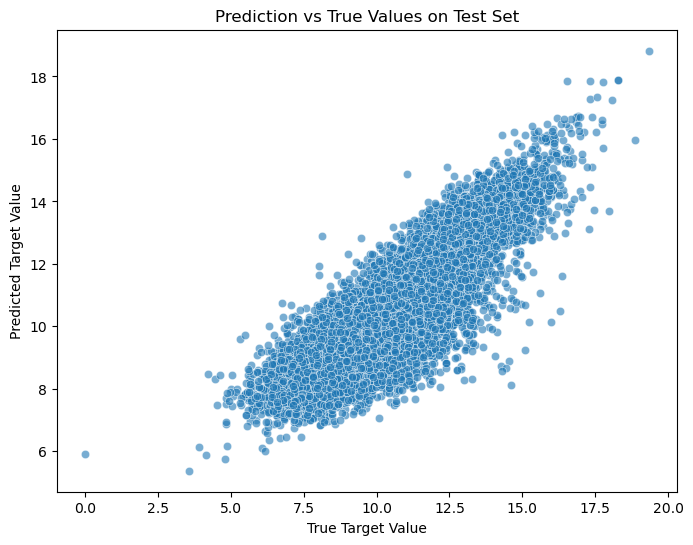

In [63]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test, y=test_predictions, alpha=0.6)
plt.xlabel('True Target Value')
plt.ylabel('Predicted Target Value')
plt.title('Prediction vs True Values on Test Set')
plt.show()

## Data cleaning - test data

In [64]:
test = pd.read_csv("test2.csv")

In [65]:
test = test.sort_values(by='JOB_42', ascending=False)
test["JOB_42"] = pd.factorize(test["JOB_42"])[0]

test = test.sort_values(by='REG_JOB', ascending=False)
test["REG_JOB"] = pd.factorize(test["REG_JOB"])[0]

test = test.sort_values(by='Economic_sector_num', ascending=False)
test["Economic_sector_num"] = pd.factorize(test["Economic_sector_num"])[0]

test = test.sort_values(by='work_description', ascending=False)
test["work_description"] = pd.factorize(test["work_description"])[0]

test = test.sort_values(by='retirement_age_cat', ascending=False)
test["retirement_age_cat"] = pd.factorize(test["retirement_age_cat"])[0]

test = test.sort_values(by='REG_FORMER', ascending=False)
test["REG_FORMER"] = pd.factorize(test["REG_FORMER"])[0]

test = test.sort_values(by='TYPE_OF_CONTRACT', ascending=False)
test["TYPE_OF_CONTRACT"] = pd.factorize(test["TYPE_OF_CONTRACT"])[0]

test = test.sort_values(by='WORK_CONDITION', ascending=False)
test["WORK_CONDITION"] = pd.factorize(test["WORK_CONDITION"])[0]

test = test.sort_values(by='labor_force_status', ascending=False)
test["labor_force_status"] = pd.factorize(test["labor_force_status"])[0]

test = test.sort_values(by='emp_contract', ascending=False)
test["emp_contract"] = pd.factorize(test["emp_contract"])[0]

test = test.sort_values(by='PRIMARY_KEY', ascending=True)

In [66]:
test_rf = pipeline.transform(test)

In [67]:
test_predictions = best_model_rf.predict(test_rf)  # Replace with your model's prediction method

# Assuming 'PRIMARY_KEY' is a column in your test set
# Create a DataFrame with PRIMARY_KEY and predicted target values
predictions_df = pd.DataFrame({
    'PRIMARY_KEY': test['PRIMARY_KEY'],  # Replace 'PRIMARY_KEY' with the correct column name
    'target': test_predictions
})

# Save the predictions to a CSV file
predictions_df.to_csv('predictions.csv', index=False, sep=',', float_format='%.6f')  # Save with US decimal notation


In [68]:
hhhhh = pd.read_csv("predictions.csv")

# Preprocessing - for Regression